In [1]:
import sys, os
sys.path.append('../src')

In [2]:
import glob
from datetime import datetime
from statistics import mean

import numpy as np
from PIL import Image
import matplotlib.pylab as plt

from prep_utils import create_limb_mask
from metrics import dice_np

In [3]:
# Create binary mask for Sun
create_limb_mask(img_size=(256, 256), radius=103)
limb_mask = np.asarray(Image.open("./limb_mask.png").convert("L"))
limb_total = (1 * (limb_mask > 0)).sum()
print(f"Total pixels = {limb_mask.shape[0] * limb_mask.shape[1]}\nWhite pixels = {limb_total}\nBlack pixels = {(1 * (limb_mask == 0)).sum()}")

Total pixels = 65536
White pixels = 33633
Black pixels = 31903


# Coronal holes

In [4]:
# Coronal holes annotations
masks = {
    "spoca": {
        "paths": glob.glob("../data/193_test/masks(spoca)/*.png")
    },
    "region": {
        "paths": glob.glob("../data/193_test/masks(region)/*.png")
    }
}
# Coronal holes predictions
predictions = {
    "custom": {
        "paths": glob.glob("../data/predictions/model_ch_custom/mask_pred/*.png")
    },
    "chimera": {
        "paths": glob.glob("../data/predictions/model_ch_chimera/mask_pred/*.png")
    },
    "region": {
        "paths": glob.glob("../data/predictions/model_ch_region/mask_pred/*.png")
    },
    "spoca": {
        "paths": glob.glob("../data/predictions/model_ch_spoca/mask_pred/*.png")
    },
}


In [5]:
# Load original mask images
for mask_type in masks:
    paths = masks[mask_type]["paths"]
    if len(paths) == 0:
        print("No images found in: " + mask_type)
    images = [np.array(Image.open(mask).convert("L").resize((256, 256))) for mask in paths]
    images = np.asarray(images, dtype=np.float32)/255  # Normalize to <0; 1>
    masks[mask_type]["images"] = images
# Load predicted mask images
for pred_type in predictions:
    paths = predictions[pred_type]["paths"]
    if len(paths) == 0:
        print("No images found in: " + pred_type)
    images = [np.array(Image.open(pred).convert("L").resize((256, 256))) for pred in paths]
    images = np.asarray(images, dtype=np.float32)/255  # Normalize to <0; 1>
    predictions[pred_type]["images"] = images

In [6]:
# Create date list
dates = [img.split("\\")[-1].replace("__SDO_AIA_AIA_193", "").replace(".png", "") for img in masks["region"]["paths"]]
dates = [datetime.strptime(date, '%Y_%m_%d__%H_%M_%S_%f') for date in dates]

data = {
    "masks": masks,
    "predictions": predictions,
    "dates": dates
}

# Dice score comparison

In [7]:
# Calculate dice score agains region growth annotations
y_true_data = data["masks"]["region"]["images"]
for pred_type in data["predictions"]:
    y_pred_data = data["predictions"][pred_type]["images"]
    dice = [dice_np(y_true, y_pred) for y_true, y_pred in zip(y_true_data, y_pred_data)]
    data["predictions"][pred_type]["dice"] = dice
    data["predictions"][pred_type]["dice_mean"] = round(mean(dice), 4)

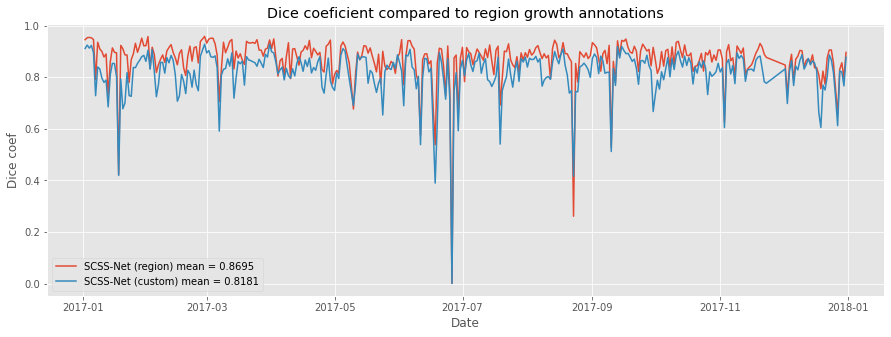

In [8]:
# Setup plot
plt.style.use('ggplot')
plt.figure(figsize=(15, 5))
plt.title("Dice coeficient compared to region growth annotations")
plt.ylabel("Dice coef")
plt.xlabel("Date")
# Plot data
plt.plot(data["dates"], data["predictions"]["region"]["dice"])
plt.plot(data["dates"], data["predictions"]["custom"]["dice"])
# Plot legend
plt.legend([f"SCSS-Net (region) mean = {data['predictions']['region']['dice_mean']}"
            , f"SCSS-Net (custom) mean = {data['predictions']['custom']['dice_mean']}"])
plt.show()

## Segmented area comparison

In [9]:
# Calculate segmented area for each prediction
for pred_type in data["predictions"]:
    y_pred_data = data["predictions"][pred_type]["images"]
    segmented_area = [(((1 * (pred > 0)).sum() * 100)/limb_total) for pred in y_pred_data]
    data["predictions"][pred_type]["segmented_area"] = segmented_area
    data["predictions"][pred_type]["segmented_area_mean"] = round(mean(segmented_area), 4)
# Calculate segmented area for each annotation
for mask_type in data["masks"]:
    masks = data["masks"][mask_type]["images"]
    segmented_area = [(((1 * (mask > 0)).sum() * 100)/limb_total) for mask in masks]
    data["masks"][mask_type]["segmented_area"] = segmented_area
    data["masks"][mask_type]["segmented_area_mean"] = round(mean(segmented_area), 4)

### Plot segmented area of predictions made by model trained on region growth annotation

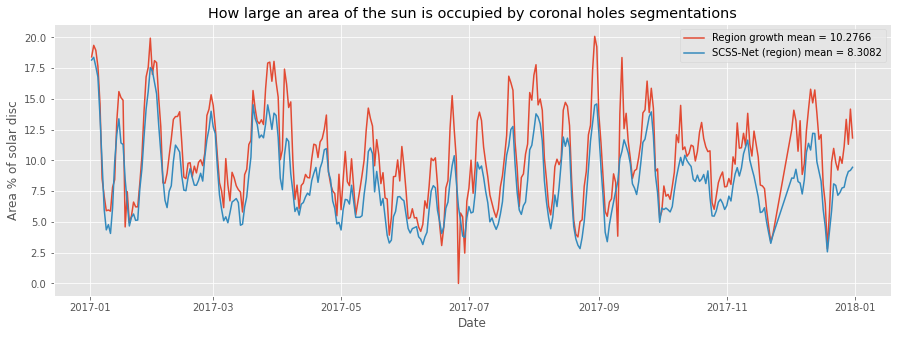

In [10]:
PREDICTION_TO_PLOT = "region"
# Setup plot
plt.style.use('ggplot')
plt.figure(figsize=(15, 5))
plt.title("How large an area of the sun is occupied by coronal holes segmentations")
plt.ylabel("Area % of solar disc")
plt.xlabel("Date")
# Plot data
plt.plot(data["dates"], data["masks"]["region"]["segmented_area"])
plt.plot(data["dates"], data["predictions"][PREDICTION_TO_PLOT]["segmented_area"])
# Plot legend
plt.legend([f"Region growth mean = {data['masks']['region']['segmented_area_mean']}"
            , f"SCSS-Net ({PREDICTION_TO_PLOT}) mean = {data['predictions'][PREDICTION_TO_PLOT]['segmented_area_mean']}"])
plt.show()

### Plot segmented area of predictions made by model trained on custom annotations

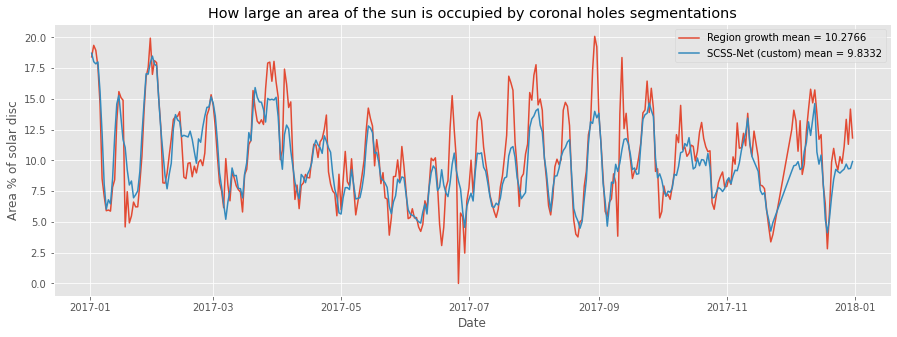

In [11]:
PREDICTION_TO_PLOT = "custom"
# Setup plot
plt.style.use('ggplot')
plt.figure(figsize=(15, 5))
plt.title("How large an area of the sun is occupied by coronal holes segmentations")
plt.ylabel("Area % of solar disc")
plt.xlabel("Date")
# Plot data
plt.plot(data["dates"], data["masks"]["region"]["segmented_area"])
plt.plot(data["dates"], data["predictions"][PREDICTION_TO_PLOT]["segmented_area"])
# Plot legend
plt.legend([f"Region growth mean = {data['masks']['region']['segmented_area_mean']}"
            , f"SCSS-Net ({PREDICTION_TO_PLOT}) mean = {data['predictions'][PREDICTION_TO_PLOT]['segmented_area_mean']}"])
plt.show()

### Plot segmented area of predictions made by model trained on chimera annotations

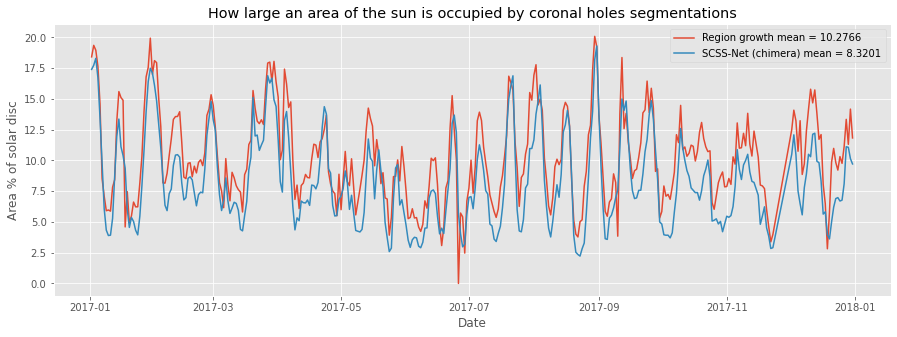

In [12]:
PREDICTION_TO_PLOT = "chimera"
# Setup plot
plt.style.use('ggplot')
plt.figure(figsize=(15, 5))
plt.title("How large an area of the sun is occupied by coronal holes segmentations")
plt.ylabel("Area % of solar disc")
plt.xlabel("Date")
# Plot data
plt.plot(data["dates"], data["masks"]["region"]["segmented_area"])
plt.plot(data["dates"], data["predictions"][PREDICTION_TO_PLOT]["segmented_area"])
# Plot legend
plt.legend([f"Region growth mean = {data['masks']['region']['segmented_area_mean']}"
            , f"SCSS-Net ({PREDICTION_TO_PLOT}) mean = {data['predictions'][PREDICTION_TO_PLOT]['segmented_area_mean']}"])
plt.show()

### Plot segmented area of predictions made by model trained on spoca compared to SPoCA annotations


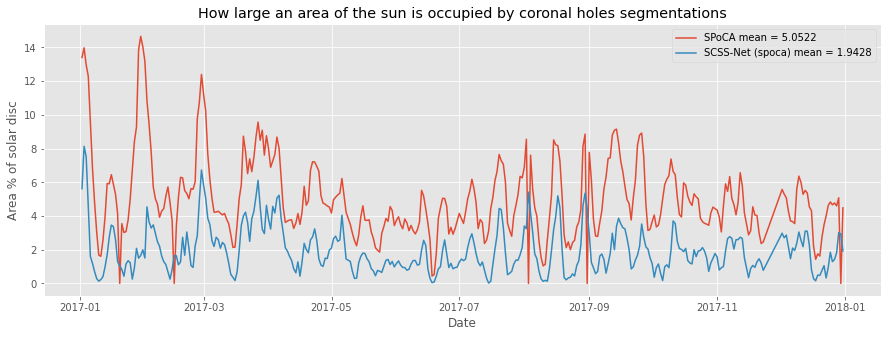

In [13]:
PREDICTION_TO_PLOT = "spoca"
# Setup plot
plt.style.use('ggplot')
plt.figure(figsize=(15, 5))
plt.title("How large an area of the sun is occupied by coronal holes segmentations")
plt.ylabel("Area % of solar disc")
plt.xlabel("Date")
# Plot data
plt.plot(data["dates"], data["masks"]["spoca"]["segmented_area"])
plt.plot(data["dates"], data["predictions"][PREDICTION_TO_PLOT]["segmented_area"])
# Plot legend
plt.legend([f"SPoCA mean = {data['masks']['spoca']['segmented_area_mean']}"
            , f"SCSS-Net ({PREDICTION_TO_PLOT}) mean = {data['predictions'][PREDICTION_TO_PLOT]['segmented_area_mean']}"])
plt.show()

# Active regions

In [14]:
# Active region annotations
masks = {
    "spoca": {
        "paths": glob.glob("../data/171_test/masks(spoca)/*.png")
    },
}
# Active region predictions
predictions = {
    "custom": {
        "paths": glob.glob("../data/predictions/model_ar_custom/mask_pred/*.png")
    },
    "spoca": {
        "paths": glob.glob("../data/predictions/model_ar_spoca/mask_pred/*.png")
    },
    "spoca_custom": {
        "paths": glob.glob("../data/predictions/model_ar_spoca_custom/mask_pred/*.png")
    },
}
# Load original mask images
for mask_type in masks:
    paths = masks[mask_type]["paths"]
    if len(paths) == 0:
        print("No images found in: " + mask_type)
    images = [np.array(Image.open(mask).convert("L").resize((256, 256))) for mask in paths]
    images = np.asarray(images, dtype=np.float32)/255  # Normalize to <0; 1>
    masks[mask_type]["images"] = images
# Load predicted mask images
for pred_type in predictions:
    paths = predictions[pred_type]["paths"]
    if len(paths) == 0:
        print("No images found in: " + pred_type)
    images = [np.array(Image.open(pred).convert("L").resize((256, 256))) for pred in paths]
    images = np.asarray(images, dtype=np.float32)/255  # Normalize to <0; 1>
    predictions[pred_type]["images"] = images
# Create date list
dates = [img.split("\\")[-1].replace("__SDO_AIA_AIA_171", "").replace(".png", "") for img in masks["spoca"]["paths"]]
dates = [datetime.strptime(date, '%Y_%m_%d__%H_%M_%S_%f') for date in dates]

data_ar = {
    "masks": masks,
    "predictions": predictions,
    "dates": dates
}

## Calculate DICE

In [15]:
# Calculate dice score agains spoca annotations
y_true_data = data_ar["masks"]["spoca"]["images"]
for pred_type in data_ar["predictions"]:
    y_pred_data = data_ar["predictions"][pred_type]["images"]
    dice = [dice_np(y_true, y_pred) for y_true, y_pred in zip(y_true_data, y_pred_data)]
    data_ar["predictions"][pred_type]["dice"] = dice
    data_ar["predictions"][pred_type]["dice_mean"] = round(mean(dice), 4)

## Calculate area

In [16]:
# Calculate segmented area for each prediction
for pred_type in data_ar["predictions"]:
    y_pred_data = data_ar["predictions"][pred_type]["images"]
    segmented_area = [(((1 * (pred > 0)).sum() * 100)/limb_total) for pred in y_pred_data]
    data_ar["predictions"][pred_type]["segmented_area"] = segmented_area
    data_ar["predictions"][pred_type]["segmented_area_mean"] = round(mean(segmented_area), 4)
# Calculate segmented area for each annotation
for mask_type in data_ar["masks"]:
    masks = data_ar["masks"][mask_type]["images"]
    segmented_area = [(((1 * (mask > 0)).sum() * 100)/limb_total) for mask in masks]
    data_ar["masks"][mask_type]["segmented_area"] = segmented_area
    data_ar["masks"][mask_type]["segmented_area_mean"] = round(mean(segmented_area), 4)

### Plot dice score for each trained model


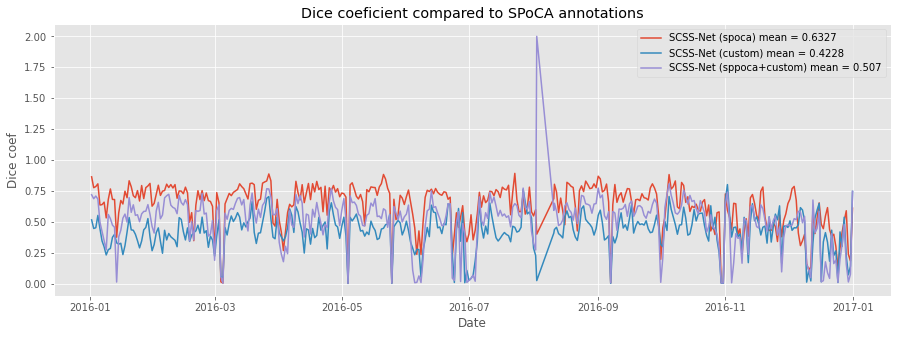

In [17]:
# Setup plot
plt.style.use('ggplot')
plt.figure(figsize=(15, 5))
plt.title("Dice coeficient compared to SPoCA annotations")
plt.ylabel("Dice coef")
plt.xlabel("Date")
# Plot data
plt.plot(data_ar["dates"], data_ar["predictions"]["spoca"]["dice"])
plt.plot(data_ar["dates"], data_ar["predictions"]["custom"]["dice"])
plt.plot(data_ar["dates"], data_ar["predictions"]["spoca_custom"]["dice"])
# Plot legend
plt.legend([f"SCSS-Net (spoca) mean = {data_ar['predictions']['spoca']['dice_mean']}"
            , f"SCSS-Net (custom) mean = {data_ar['predictions']['custom']['dice_mean']}"
            , f"SCSS-Net (sppoca+custom) mean = {data_ar['predictions']['spoca_custom']['dice_mean']}"])
plt.show()

### Plot segmented area of predictions made by model trained on spoca annotanions compared to SPoCA annotations


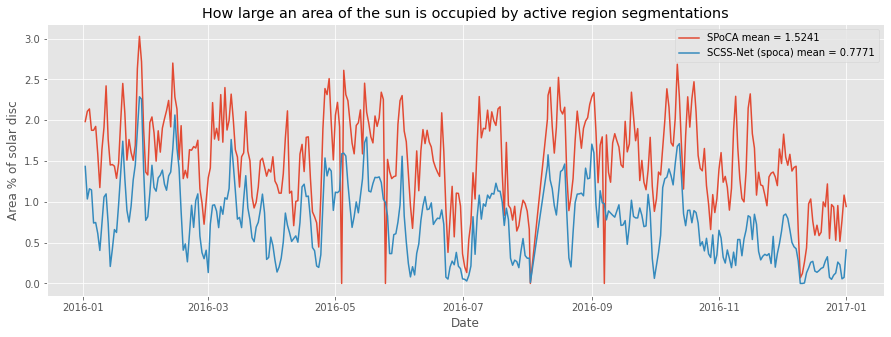

In [18]:
PREDICTION_TO_PLOT = "spoca"
# Setup plot
plt.style.use('ggplot')
plt.figure(figsize=(15, 5))
plt.title("How large an area of the sun is occupied by active region segmentations")
plt.ylabel("Area % of solar disc")
plt.xlabel("Date")
# Plot data
plt.plot(data_ar["dates"], data_ar["masks"]["spoca"]["segmented_area"])
plt.plot(data_ar["dates"], data_ar["predictions"][PREDICTION_TO_PLOT]["segmented_area"])
# Plot legend
plt.legend([f"SPoCA mean = {data_ar['masks']['spoca']['segmented_area_mean']}"
            , f"SCSS-Net ({PREDICTION_TO_PLOT}) mean = {data_ar['predictions'][PREDICTION_TO_PLOT]['segmented_area_mean']}"])
plt.show()

### Plot segmented area of predictions made by model trained on custom annotations compared to SPoCA annotations


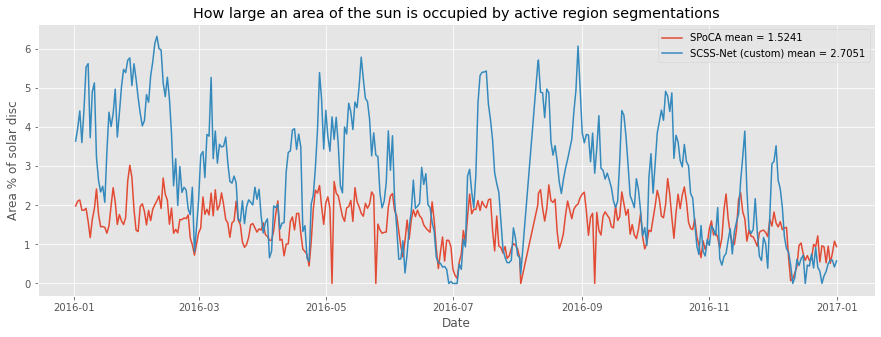

In [19]:
PREDICTION_TO_PLOT = "custom"
# Setup plot
plt.style.use('ggplot')
plt.figure(figsize=(15, 5))
plt.title("How large an area of the sun is occupied by active region segmentations")
plt.ylabel("Area % of solar disc")
plt.xlabel("Date")
# Plot data
plt.plot(data_ar["dates"], data_ar["masks"]["spoca"]["segmented_area"])
plt.plot(data_ar["dates"], data_ar["predictions"][PREDICTION_TO_PLOT]["segmented_area"])
# Plot legend
plt.legend([f"SPoCA mean = {data_ar['masks']['spoca']['segmented_area_mean']}"
            , f"SCSS-Net ({PREDICTION_TO_PLOT}) mean = {data_ar['predictions'][PREDICTION_TO_PLOT]['segmented_area_mean']}"])
plt.show()

### Plot segmented area of predictions made by model trained on spoca+custom annotations compared to SPoCA annotations


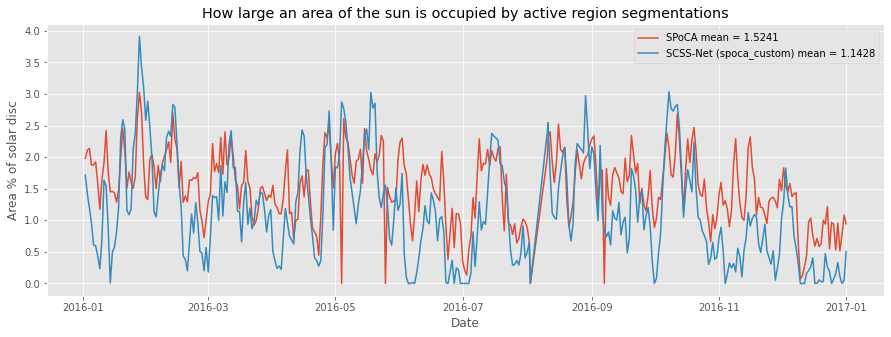

In [20]:
PREDICTION_TO_PLOT = "spoca_custom"
# Setup plot
plt.style.use('ggplot')
plt.figure(figsize=(15, 5))
plt.title("How large an area of the sun is occupied by active region segmentations")
plt.ylabel("Area % of solar disc")
plt.xlabel("Date")
# Plot data
plt.plot(data_ar["dates"], data_ar["masks"]["spoca"]["segmented_area"])
plt.plot(data_ar["dates"], data_ar["predictions"][PREDICTION_TO_PLOT]["segmented_area"])
# Plot legend
plt.legend([f"SPoCA mean = {data_ar['masks']['spoca']['segmented_area_mean']}"
            , f"SCSS-Net ({PREDICTION_TO_PLOT}) mean = {data_ar['predictions'][PREDICTION_TO_PLOT]['segmented_area_mean']}"])
plt.show()